## Imports

In [1]:
import h5py
import numpy as np
import scipy as sp
import skimage as ski
import matplotlib.pyplot as plt

from fusion import optimize
from utils import hyperspectral2RGB, hyperspectral2RGBvolume, bin_data
from utils import RESOURCES_PATH

XY_DIM = 128
CMOS_PATH = RESOURCES_PATH / "kidney" / "kidney_cells_520_610_w4_rec_Hil2D_FOVcorrected.mat"
SPC_PATH = RESOURCES_PATH / "kidney" / "520_kidneyCells_550_550_610_SPC_raw_proc_tlxy.mat"
LAMBDA_PATH = RESOURCES_PATH / "kidney" / "610_Lambda_L16.mat"

## Data loading

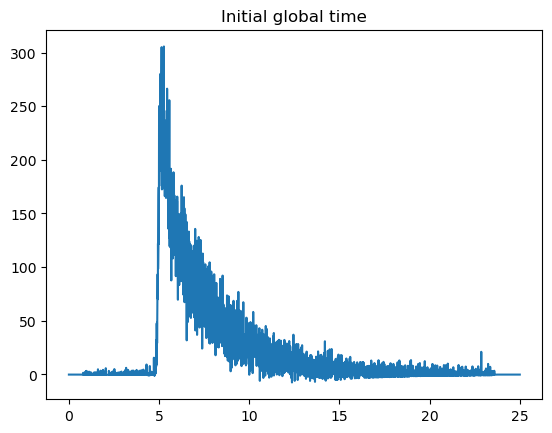

In [51]:
with h5py.File(CMOS_PATH, "r") as f:
    cmos = np.array(h5py.File(CMOS_PATH)["I"])

if cmos.ndim == 3:
    cmos = np.transpose(cmos, (1, 2, 0))
    zdim = cmos.shape[2]
    cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM, zdim))
    cmos = np.transpose(cmos, (2, 1, 0))
else:
    cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM))
    cmos = np.transpose(cmos, (1, 0))
    plt.imshow(cmos)
    plt.title("Initial cmos")
    plt.show()

cmos = cmos / cmos.max()

spc = sp.io.loadmat(SPC_PATH)["im"]
t = np.squeeze(sp.io.loadmat(SPC_PATH)["t"])
spc[:, :, 0, 0] = spc[:, :, 1, 0]
# sp.io.savemat('spcOriginal.mat', {'spc': spc})
lam = np.squeeze(sp.io.loadmat(LAMBDA_PATH)["lambda"])

time_decay = np.sum(spc, axis=(1, 2, 3))
plt.plot(t, time_decay)
plt.title("Initial global time")
plt.show()

## Time binning

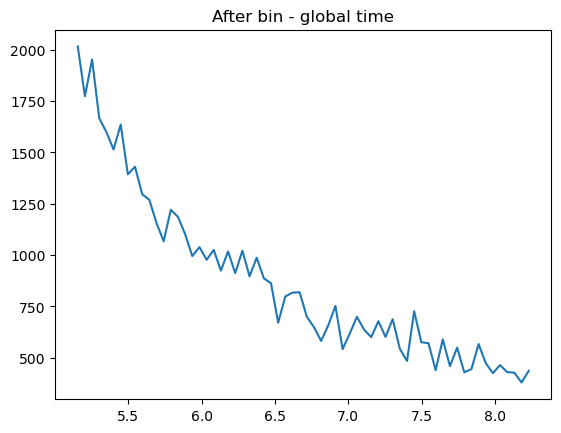

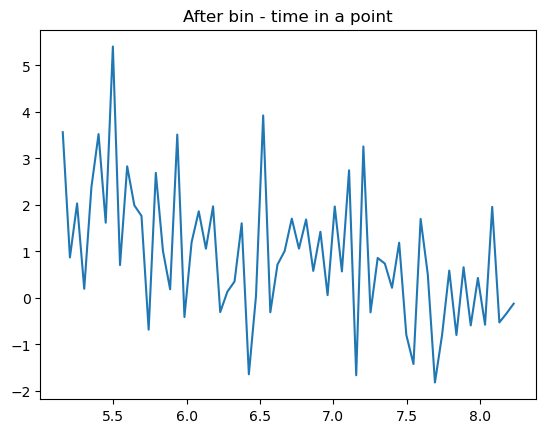

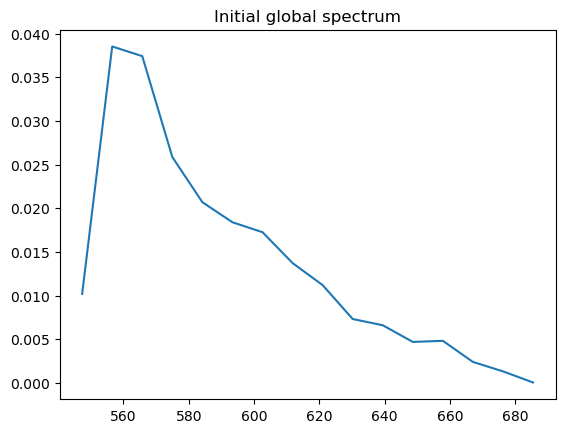

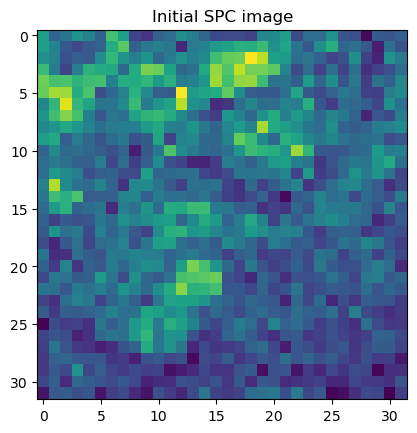

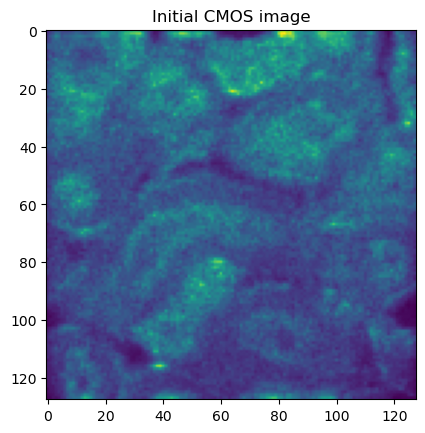

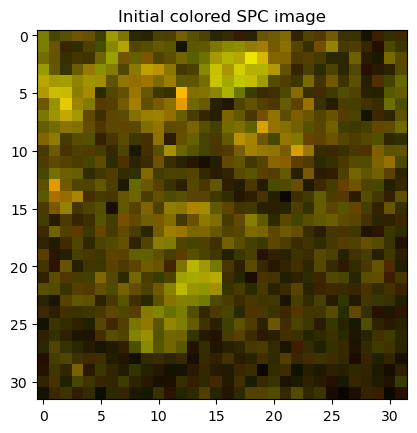

In [52]:
# data binning
t, spc, dt = bin_data(spc, t, 0.05)

# cut the time
curve = np.squeeze(np.sum(spc, axis=(1, 2, 3)))
val = np.max(curve)
pos_max = np.argmax(curve)
curve = curve[pos_max:]
b = np.argmin(abs(curve - curve[0] * (1 - np.exp(-1 / 5))))
# curve=curve[0:b]
spc = spc[pos_max: (pos_max + b), :, :, :]
t = t[pos_max: (pos_max + b)]

time_decay = np.sum(spc, axis=(1, 2, 3))
plt.plot(t, time_decay)
plt.title("After bin - global time")
plt.show()

plt.plot(t, np.sum(spc[:, :, 12, 20], axis=1))
plt.title("After bin - time in a point")
plt.show()

spc = spc / np.max(spc)

plt.plot(lam, np.mean(spc, axis=(0, 2, 3)))
plt.title("Initial global spectrum")
plt.show()

plt.imshow(np.mean(spc, axis=(0, 1)))
plt.title("Initial SPC image")
plt.show()

plt.imshow(cmos[5, :, :])
plt.title("Initial CMOS image")
plt.show()

plt.imshow(hyperspectral2RGB(lam, np.mean(spc, axis=0)))
plt.title("Initial colored SPC image")
plt.show()

# plt.plot(lam,np.mean(spc[:,:,10,11],axis=0))
# plt.plot(lam,np.mean(spc[:,:,16,19],axis=0))
# plt.title('Initial spectrum specific point')
# plt.show()

# plt.plot(spc[:,12,20])
# plt.title('Initial spectrum small bead')
# plt.show()
# ==================================

# for i in range(len(spc)):
#     spc[i] = spc[i]/spc[i].max()
# mask = ski.transform.resize(np.all(mask, axis=0), (32, 32))
# spc[:, mask] = 0


## Fusion through optimization

In [53]:
x = optimize(spc=spc, cmos=cmos, iterations=30)
x = x.cpu().detach().numpy()
np.save(RESOURCES_PATH / "x.npy", x)


Iteration 1 | Spectral: 0.0040 | Spatial: 0.0072 | Non Neg: 0.0006 | 
Iteration 2 | Spectral: 0.0037 | Spatial: 0.0065 | Non Neg: 0.0005 | 
Iteration 3 | Spectral: 0.0035 | Spatial: 0.0058 | Non Neg: 0.0005 | 
Iteration 4 | Spectral: 0.0032 | Spatial: 0.0052 | Non Neg: 0.0005 | 
Iteration 5 | Spectral: 0.0031 | Spatial: 0.0047 | Non Neg: 0.0004 | 
Iteration 6 | Spectral: 0.0029 | Spatial: 0.0042 | Non Neg: 0.0004 | 
Iteration 7 | Spectral: 0.0028 | Spatial: 0.0038 | Non Neg: 0.0004 | 
Iteration 8 | Spectral: 0.0027 | Spatial: 0.0034 | Non Neg: 0.0004 | 
Iteration 9 | Spectral: 0.0026 | Spatial: 0.0031 | Non Neg: 0.0004 | 
Iteration 10 | Spectral: 0.0026 | Spatial: 0.0028 | Non Neg: 0.0004 | 
Iteration 11 | Spectral: 0.0025 | Spatial: 0.0025 | Non Neg: 0.0004 | 
Iteration 12 | Spectral: 0.0025 | Spatial: 0.0023 | Non Neg: 0.0004 | 
Iteration 13 | Spectral: 0.0025 | Spatial: 0.0021 | Non Neg: 0.0004 | 
Iteration 14 | Spectral: 0.0024 | Spatial: 0.0019 | Non Neg: 0.0004 | 
Iteration 15 | 

## Visualize results

In [54]:
from ipywidgets import interact

In [57]:
zxy = np.sum(x, axis=(0, 1))
zxy /= zxy.max()

slices_rgb = hyperspectral2RGBvolume(lam, np.mean(x, axis=0))

means_spectrums = np.mean(x, axis=(0, 3, 4)).T
min_mean_spectrum = np.min(means_spectrums)
max_mean_spectrum = np.max(means_spectrums)

means_times = np.mean(x, axis=(1, 3, 4)).T
print(means_times.shape)
min_mean_times = np.min(means_times)
max_mean_times = np.max(means_times)


def plot_across_z(index_z=9):
    _, ax = plt.subplots(2, 2, figsize=(8, 8))
    ax[0, 0].imshow(zxy[index_z], cmap="gray", vmin=0, vmax=1)
    ax[0, 0].set_title(f"Fused Image, z={index_z}")

    ax[0, 1].imshow(slices_rgb[index_z])
    ax[0, 1].set_title(f"Colored with spectrum")

    ax[1, 0].plot(lam, means_spectrums[index_z], label=f"{i}")
    ax[1, 0].set_ylim(min_mean_spectrum, max_mean_spectrum)
    ax[1, 0].set_title(f"Fused Spectrum, z={index_z}")

    ax[1, 1].plot(t, means_times[index_z], label=f"{i}")
    ax[1, 1].set_ylim(min_mean_times, max_mean_times)
    ax[1, 1].set_title(f"Fused Time, z={index_z}")

    plt.tight_layout()
    plt.show()


interact(plot_across_z, index_z=(0, len(zxy), 1));

(25, 64)


interactive(children=(IntSlider(value=9, description='index_z', max=25), Output()), _dom_classes=('widget-inte…

In [70]:
reconstructed_spectrums = np.mean(x, axis=(0, 2))
reconstructed_times = np.mean(x, axis=(1, 2))

def spectrum_time_in_a_point(i=0, j=0):
    _, ax = plt.subplots(1, 3, figsize=(12, 4))
    z_index = np.argmax(means_spectrums.sum(axis=1))
    ax[0].imshow(slices_rgb[z_index])
    ax[0].scatter([j], [i], c="b")
    ax[0].set_title(f"Colored with spectrum")
    
    ax[1].plot(lam, reconstructed_spectrums[:, i, j])
    ax[1].set_title(f"Spectrum in ({i},{j})")
    
    ax[2].plot(t, reconstructed_times[:, i, j])
    ax[2].set_title(f"Time in ({i},{j})")
    plt.tight_layout()
    plt.show()
    
interact(spectrum_time_in_a_point, i=(0, x.shape[-2], 1), j=(0, x.shape[-1], 1));

interactive(children=(IntSlider(value=0, description='i', max=128), IntSlider(value=0, description='j', max=12…